In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']
print(X.shape)
y.shape

(70000, 784)


(70000,)

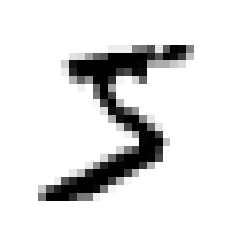

In [6]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [23]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [27]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [28]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
recall_score(y_train_5, y_train_pred)

0.8370879772350012


0.6511713705958311

In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [30]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [31]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)


In [32]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

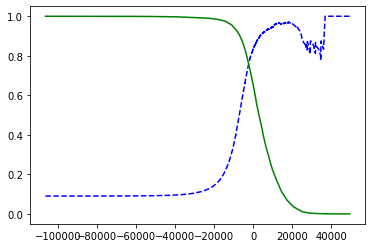

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
recall_score(y_train_5, y_train_pred_90)

0.9000345901072293


0.4799852425751706

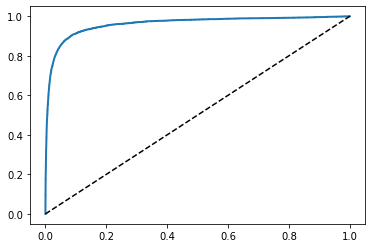

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds, = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

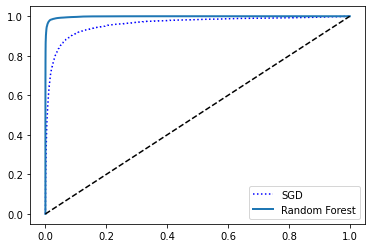

In [43]:
'''from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")'''

#need scores not probabilities
'''y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_foreset, thresholds_forest = roc_curve(y_train_5, y_scores_forest)'''

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_foreset, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
class classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO).

In [45]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [46]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
np.argmax(some_digit_scores)
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
sgd_clf.classes_[5]

5

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance
and pass a binary classifier to its constructor

In [50]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
len(ovo_clf.estimators_)

45

`RandomForestClassifier` is just as easy

In [52]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [54]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Focus the plot on the errors